# OSMnx features demo

Author: [Geoff Boeing](https://geoffboeing.com/)

Get street networks and other spatial data anywhere in the world from OpenStreetMap then analyze and visualize them.

More info:

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [Documentation and install instructions](https://osmnx.readthedocs.io)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Journal article and citation info](http://geoffboeing.com/publications/osmnx-complex-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)

In [1]:
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
ox.config(use_cache=True, log_console=True)
ox.__version__

'0.12.1'

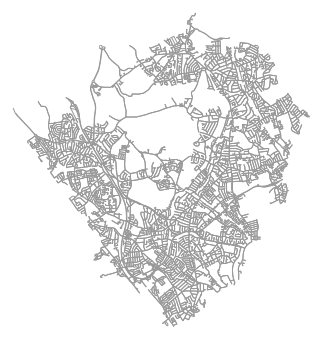

In [2]:
# get a graph for some city
G = ox.graph_from_place('City of Westminster', network_type='drive')
fig, ax = ox.plot_graph(G, node_size=0)
fig.savefig('images/city_of_westminster.png', dpi=500, bbox_inches='tight')

In [ ]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

In [ ]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

In [ ]:
# see more stats (mostly topological stuff) with extended_stats
more_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True) #use arguments to turn other toplogical analyses on/off
for key in sorted(more_stats.keys()):
    print(key)

In [ ]:
# pull up some stat's value
more_stats['radius']

In [ ]:
# save graph to disk as shapefile (for GIS) or graphml file (for gephi etc)
ox.save_graph_shapefile(G, filename='mynetwork_shapefile')
ox.save_graphml(G, filename='mynetwork.graphml')

## Visualize street centrality

In [ ]:
# edge closeness centrality: convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))

In [ ]:
# list of edge values for the orginal graph
ev = [edge_centrality[edge + (0,)] for edge in G.edges()]

# color scale converted to list of colors for graph edges
norm = colors.Normalize(vmin=min(ev)*0.8, vmax=max(ev))
cmap = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
ec = [cmap.to_rgba(cl) for cl in ev]

# color the edges in the original graph with closeness centralities in the line graph
fig, ax = ox.plot_graph(G, bgcolor='k', axis_off=True, node_size=0,
                        edge_color=ec, edge_linewidth=1.5, edge_alpha=1)

## Routing

In [ ]:
# get the nearest network node to each point
orig_node = ox.get_nearest_node(G, (37.828903, -122.245846))
dest_node = ox.get_nearest_node(G, (37.812303, -122.215006))

In [ ]:
# find the route between these nodes then plot it
route = nx.shortest_path(G, orig_node, dest_node, weight='length')
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [ ]:
# how long is our route in meters?
nx.shortest_path_length(G, orig_node, dest_node, weight='length')

In [ ]:
# how far is it between these two nodes as the crow flies?
ox.great_circle_vec(G.nodes[orig_node]['y'], G.nodes[orig_node]['x'],
                    G.nodes[dest_node]['y'], G.nodes[dest_node]['x'])

## Get networks other ways

make queries less ambiguous to help the geocoder out if it's not finding what you're looking for

In [ ]:
# make query an unambiguous dict to help the geocoder find specifically what you're looking for
place = {'city' : 'San Francisco',
         'state' : 'California',
         'country' : 'USA'}
G = ox.graph_from_place(place, network_type='drive')
fig, ax = ox.plot_graph(G, fig_height=12, node_size=0, edge_linewidth=0.5)

In [ ]:
# add elevation to nodes automatically, calculate edge grades, plot network
from keys import google_elevation_api_key
G = ox.add_node_elevations(G, api_key=google_elevation_api_key)
G = ox.add_edge_grades(G)
nc = ox.get_node_colors_by_attr(G, 'elevation', cmap='plasma', num_bins=20)
fig, ax = ox.plot_graph(G, fig_height=6, node_color=nc, node_size=12, node_zorder=2, edge_color='#dddddd')

example: create impedance functions to route around hills: https://github.com/gboeing/osmnx-examples/blob/master/notebooks/12-node-elevations-edge-grades.ipynb

In [ ]:
# you can get networks anywhere in the world
G = ox.graph_from_place('Sinalunga, Italy', network_type='all')
fig, ax = ox.plot_graph(G, fig_height=8, node_size=0, edge_linewidth=0.5)

In [ ]:
# or get network by coordinates, bounding box, or any custom polygon shape
# useful when OSM just doesn't have a polygon for the place you want
wurster_hall = (37.870605, -122.254830)
one_mile = 1609 #meters
G = ox.graph_from_point(wurster_hall, distance=one_mile, network_type='drive')
fig, ax = ox.plot_graph(G, fig_height=8, node_size=0)

examples of getting networks by coordinates, bounding box, or any custom polygon shape: https://github.com/gboeing/osmnx-examples/blob/master/notebooks/01-overview-osmnx.ipynb

## Get other infrastructure types

like rail or electric grids

In [ ]:
# get rail network
# note this is rail *infrastructure* and thus includes crossovers, sidings, spurs, yards, etc
# for station-based rail network, you should prob download a station adjacency matrix elsewhere
G = ox.graph_from_place('New York City, New York',
                        retain_all=False, truncate_by_edge=True, simplify=True,
                        network_type='none', infrastructure='way["railway"~"subway"]')

fig, ax = ox.plot_graph(G, fig_height=10, node_size=0)